# Introduzione


La seguente relazione verte sull'implementazione ed analisi del modello 2D projected NFW profile. Esso è una descrizione del profilo di densità proiettato degli aloni di materia oscura circondanti galassie e ammassi di galassie.
In prima analisi si implementerà in linguaggio python la complessa funzione analitica del modello, successivamente si vedrà il suo comportamento al variare dei parametri e infine si confronterà con dati sperimentali, realizzando un best fit e utilizzando il Markov Chain Monte Carlo.
Di seguito i comandi per installare e importare i pacchetti necessari al programma.

In [24]:
!pip install emcee
!pip install pygtc
!apt-get install -y fonts-liberation

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-liberation is already the newest version (1:1.07.4-11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits
import emcee
import pygtc
from scipy.optimize import minimize

# Configurazione del font
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['DejaVu Sans']

# Implementazione ed analisi della funzione

Di seguito la definizione della funzione $Σ$, dipendente da 4 parametri:
*   $R$ : distanza dal centro dell'alone di materia oscura espressa in Mpc
*   $M$ : massa dell'alone di materia oscura espressa in masse solari
*   $c$ : concentrazione
*   $z$ : redshift

Al suo interno inoltre son presenti diverse costanti racchiuse in $\rho_{m}$, il calcolo del raggio cartteristico $r_{s}$ e la caratterizzazione di una funzione a tratti che descrive l'andamento all'interno e all'esterno del raggio caratteristico $r_{s}$.


In [22]:
def nfw_density_profile(R, M, c, z):

    rho_m = 0.286 * (0.7**2) * 2.7751428946e11  # M_sun / Mpc^3

    r_s = (3. * M / (4. * 200 * np.pi * rho_m * c**3 * (1+z)**3)) ** (1/3)
    rho_s = (200. * c**3 * rho_m * (1+z)**3 )     /     (3.*(np.log(1 + c) - c / (1 + c)))

    # Funzione f(x)
    x = R / r_s
    f_x = np.piecewise(
        x,
        [x < 1, x==1 , x > 1],
        [
            lambda x: (1. / (x**2 - 1))  *  (1. - (2. / np.sqrt(1 - x**2)) * np.arctanh(np.sqrt((1 - x) / (1 + x)))),
            lambda x: 1./3 ,
            lambda x: (1. / (x**2 - 1))  *  (1. - 2. / np.sqrt(x**2 - 1) * np.arctan(np.sqrt((x - 1) / (1 + x))))
        ]
    )

    # Profilo di densità proiettato
    Sigma = 2 * r_s * rho_s * f_x
    return np.asarray(Sigma)

Il seguente segmento di codice concerne la visualizzione della funzione $Σ$ al variare dei parametri $M$ e $c$, a $z$ fissato e su un piano distanza-$Σ$.
Il primo grafico mostra le 9 combinazioni di 3 valori scelti di ambedue le variabili che condividono gli stessi assi a scala logaritica per una migliore visualizzazione.
Il secondo invece mette in risalto l'azione dei parametri sulla funzione $Σ$, infatti $c$ influenza la pendenza ed $M$ trasla la curva lungo le ordinate.

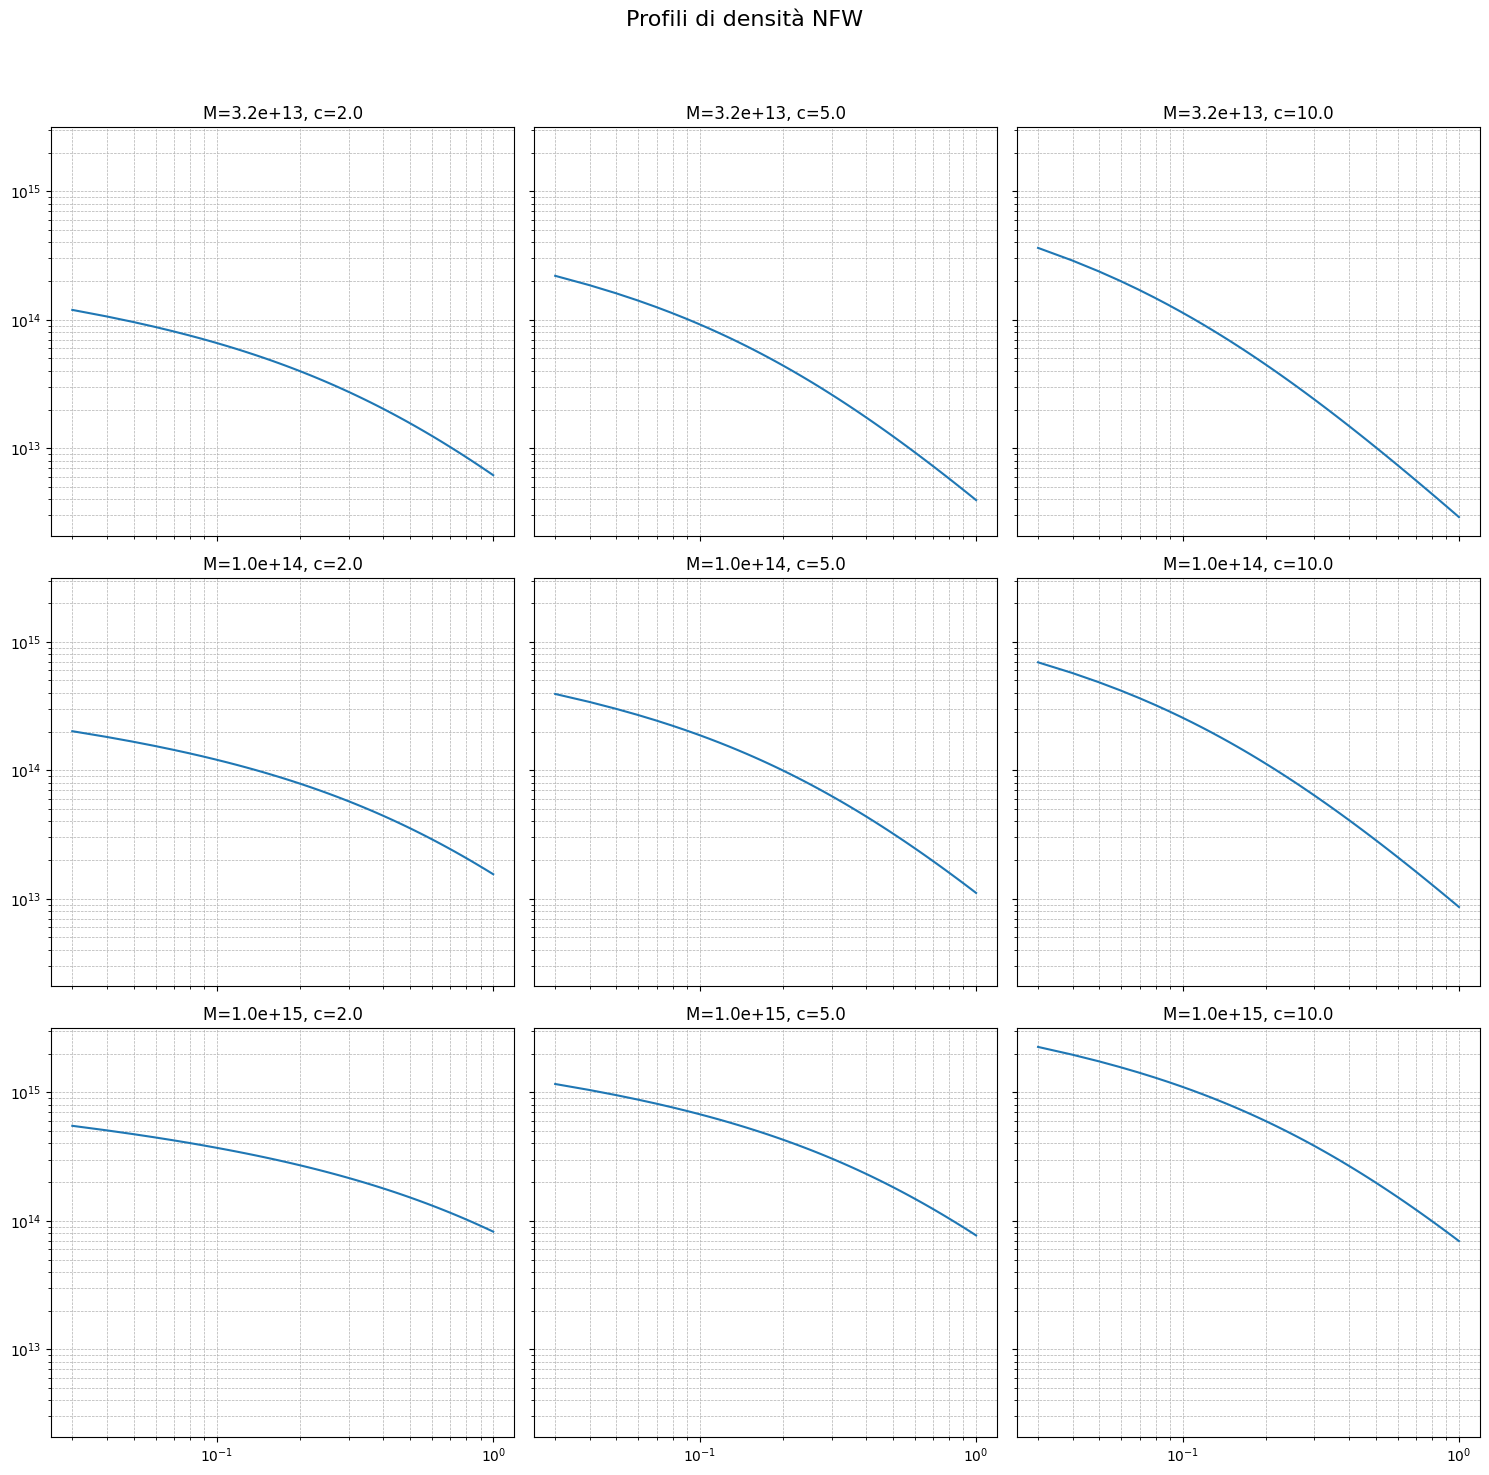

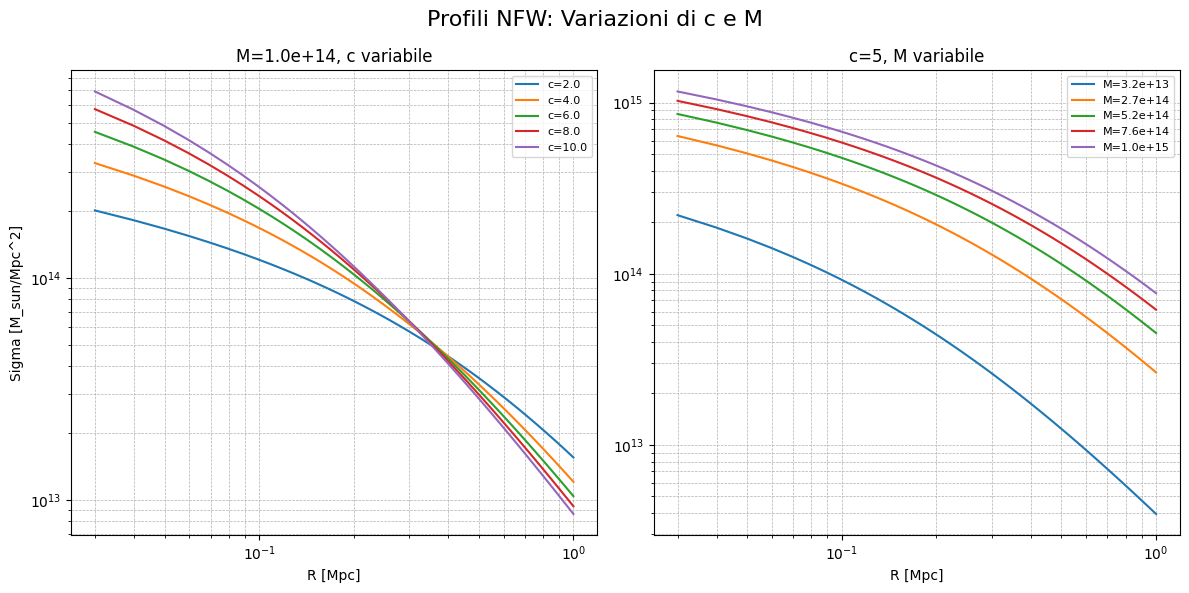

In [23]:
# Parametri
R = np.linspace(0.03, 1.0, 100)  # Intervallo dei raggi
masses = [10**13.5, 10**14.0, 10**15.0]  # Masse in M_sun
concentrations = [2., 5., 10.]  # Concentrazioni
z = 0.0  # Redshift
fixed_mass = 10**14  # Massa fissata
fixed_concentration = 5  # Concentrazione fissata
variable_masses = np.linspace(10**13.5, 10**15, 5)
variable_concentrations = np.linspace(2, 10, 5)

# Creazione del grafico con subplot
fig, axes = plt.subplots(len(masses), len(concentrations), figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle("Profili di densità NFW", fontsize=16)

# Grafici principali
for i, M in enumerate(masses):
    for j, c in enumerate(concentrations):
        Sigma = nfw_density_profile(R, M, c, z)
        ax = axes[i, j]
        ax.plot(R, Sigma, label=f"M={M:.1e}, c={c}")
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        ax.set_title(f"M={M:.1e}, c={c}")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Creazione del secondo grafico per variazioni di M e c
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Profili NFW: Variazioni di c e M", fontsize=16)

# Primo plot: M fissato, c variabile
ax1 = axes[0]
for c in variable_concentrations:
    Sigma = nfw_density_profile(R, fixed_mass, c, z)
    ax1.plot(R, Sigma, label=f"c={c}")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.set_title(f"M={fixed_mass:.1e}, c variabile")
ax1.set_xlabel("R [Mpc]")
ax1.set_ylabel("Sigma [M_sun/Mpc^2]")
ax1.legend(fontsize=8)

# Secondo plot: c fissato, M variabile
ax2 = axes[1]
for M in variable_masses:
    Sigma = nfw_density_profile(R, M, fixed_concentration, z)
    ax2.plot(R, Sigma, label=f"M={M:.1e}")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.set_title(f"c={fixed_concentration}, M variabile")
ax2.set_xlabel("R [Mpc]")
ax2.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Fit dei dati

Di seguito la prima visualizzazione dei dati contenenti profili di densità di 40103 aloni di materia oscura estratti da una simulazione cosmologica N-body.
Innanzitutto si è diviso il catalogo in 5 intervalli di ricchezza aventi come estremi $λ = [15, 20 ,30, 45, 60, 200]$, per ciscun bin si è poi calcolato il redshift medio e il profilo di densità medio con relativa deviazione standard, graficando i risultati.

Intervallo 15 <= Lambda < 20: z_mean = 0.460
Intervallo 20 <= Lambda < 30: z_mean = 0.464
Intervallo 30 <= Lambda < 45: z_mean = 0.459
Intervallo 45 <= Lambda < 60: z_mean = 0.456
Intervallo 60 <= Lambda < 200: z_mean = 0.441


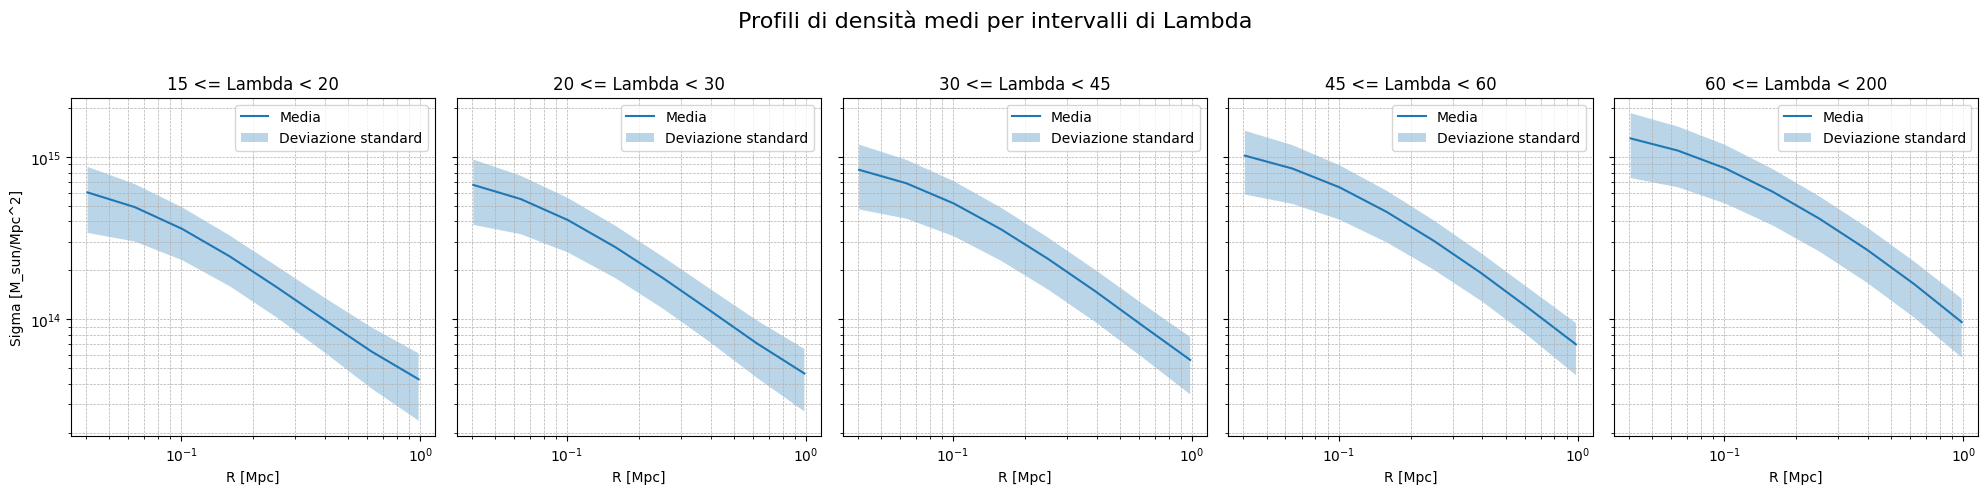

In [10]:
data = fits.open("halo_catalog.fit")[1].data
R_values = np.load("R_values.npy")

redshift = data['Z']
richness = data['LAMBDA_TR']
density_profiles = data['SIGMA_of_R']

# Definizione degli intervalli di ricchezza
lambda_bins = [15, 20, 30, 45, 60, 200]

# Calcolo delle statistiche per ciascun intervallo
bin_results = []
for i in range(len(lambda_bins) - 1):
    lower, upper = lambda_bins[i], lambda_bins[i + 1]
    mask = (richness >= lower) & (richness < upper)

    if np.sum(mask) == 0:
        print(f"Nessun dato nell'intervallo {lower} <= Lambda < {upper}")
        continue

    redshift_mean = np.mean(redshift[mask])
    density_mean = np.mean(density_profiles[mask], axis=0)
    density_std = np.std(density_profiles[mask], axis=0)

    bin_results.append({
        "lambda_range": (lower, upper),
        "redshift_mean": redshift_mean,
        "density_mean": density_mean,
        "density_std": density_std
    })


# Visualizzazione dei risultati
fig, axes = plt.subplots(1, len(bin_results), figsize=(20, 5), sharey=True)
fig.suptitle("Profili di densità medi per intervalli di Lambda", fontsize=16)

for ax, result in zip(axes, bin_results):
    ax.plot(R_values, result["density_mean"], label="Media")
    ax.fill_between(
        R_values,
        result["density_mean"] - result["density_std"],
        result["density_mean"] + result["density_std"],
        alpha=0.3, label="Deviazione standard"
    )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"{result['lambda_range'][0]} <= Lambda < {result['lambda_range'][1]}")
    ax.set_xlabel("R [Mpc]")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.legend()

    print(f"Intervallo {result['lambda_range'][0]} <= Lambda < {result['lambda_range'][1]}: z_mean = {result['redshift_mean']:.3f}")

axes[0].set_ylabel("Sigma [M_sun/Mpc^2]")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Nell'ultima sezione si è computato il best fit del modello per ciascun intervallo di ricchezza. Si sono ottimizzati i parametri $M$ e $c$ tramite la funzione di Likelyhood, utilizzando il valore di redshift medio calcolato e assumendo un errore gaussiano sui profili di densità.
Trovati i valori $M^{*}$ ed $c^{*}$ si è utilizzato l'algoritmo di Markov Chain Monte Carlo, implementato nel software *emcee*, per il calcolo degli errori relativi a questi.
Per ciascun intervallo di ricchezza si sono genarati 3 grafici. I primi due contengono la curva di best fit con relativa banda di errore, in particolare è stato anche graficato il modello utilizzando gli ultimi 100 valori di $M$ e $c$ estratti dalle catene dell'algoritmo. Il terzo, invece, è un grafico triangolare che mostra la funzione di distribuzione dei parametri.
Aggiuntivamente si è calcolato il $χ^2$ per ciascun fit, assicurandosi così una stima della bontà del fit.

Esecuzione di emcee per bin 15 <= Lambda < 20...


100%|██████████| 3000/3000 [00:36<00:00, 82.56it/s] 


Risultati per bin 15 <= Lambda < 20:
M = 14.299 (-0.103/+0.094)
c = 2.960 (-1.027/+1.436)
Chi-quadrato per il best fit: 0.597


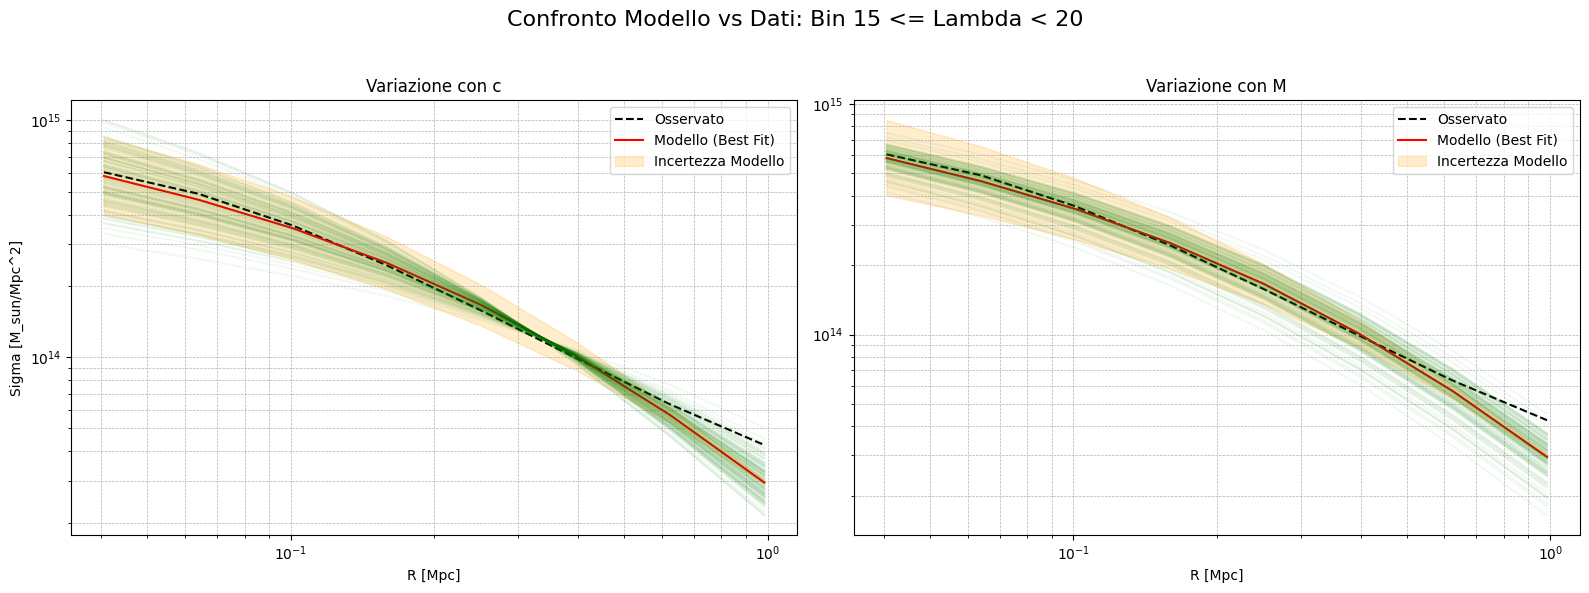

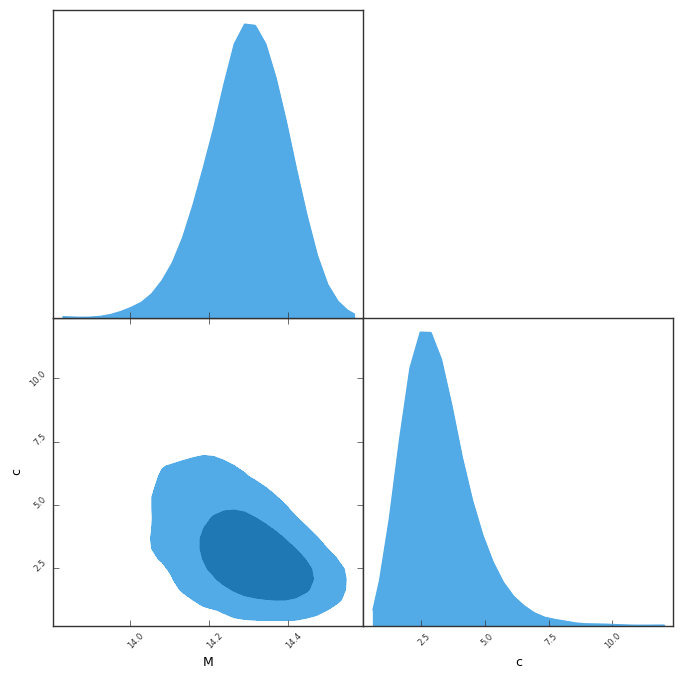

Esecuzione di emcee per bin 20 <= Lambda < 30...


100%|██████████| 3000/3000 [00:34<00:00, 87.37it/s]


Risultati per bin 20 <= Lambda < 30:
M = 14.378 (-0.100/+0.091)
c = 3.077 (-1.022/+1.392)
Chi-quadrato per il best fit: 0.497


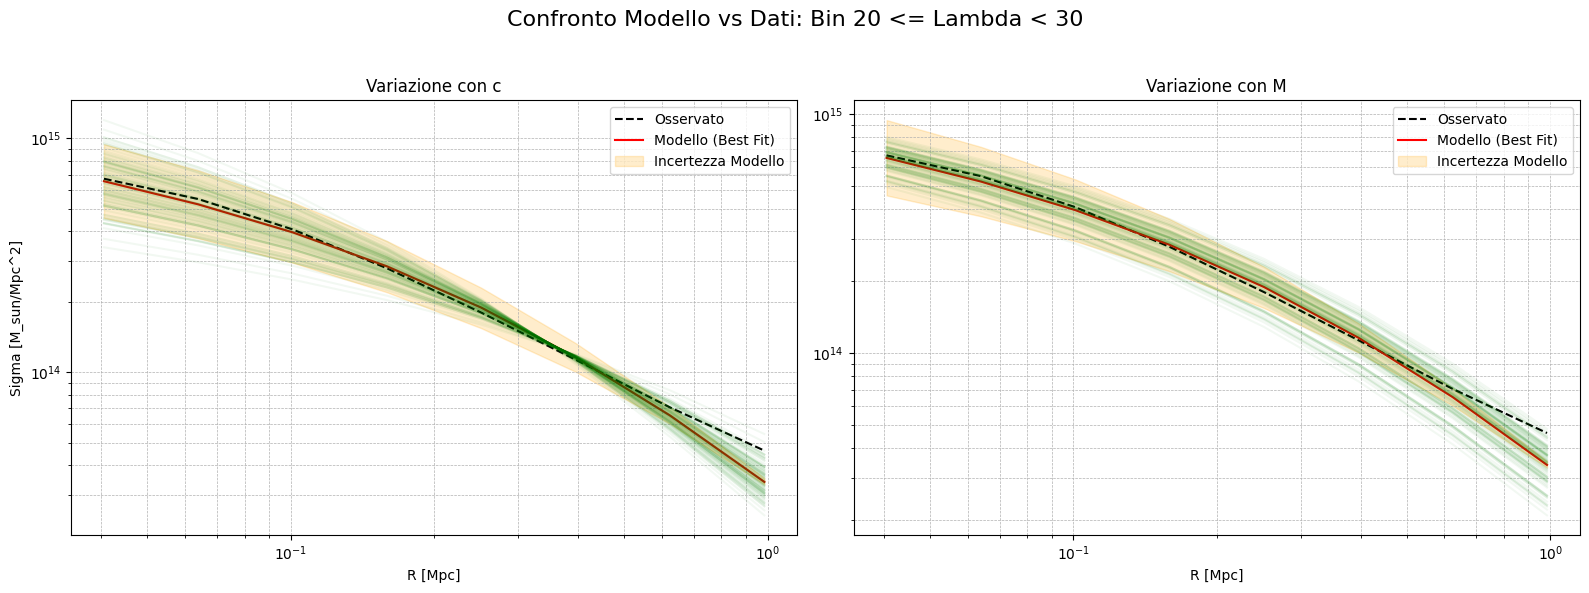

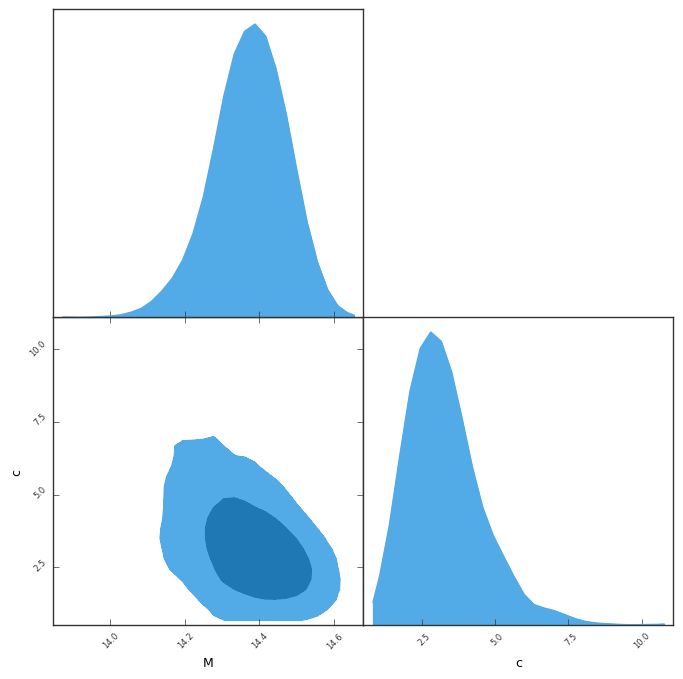

Esecuzione di emcee per bin 30 <= Lambda < 45...


100%|██████████| 3000/3000 [00:49<00:00, 60.01it/s]


Risultati per bin 30 <= Lambda < 45:
M = 14.543 (-0.099/+0.088)
c = 3.281 (-1.019/+1.313)
Chi-quadrato per il best fit: 0.295


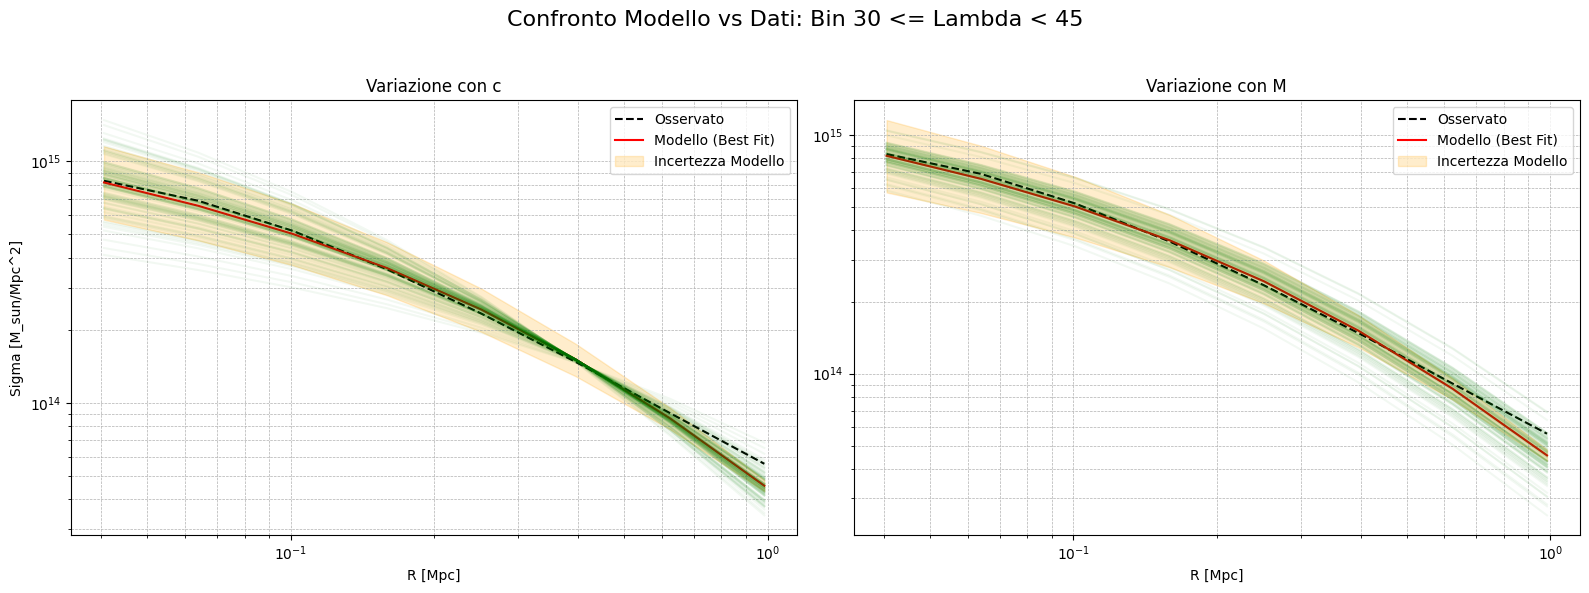

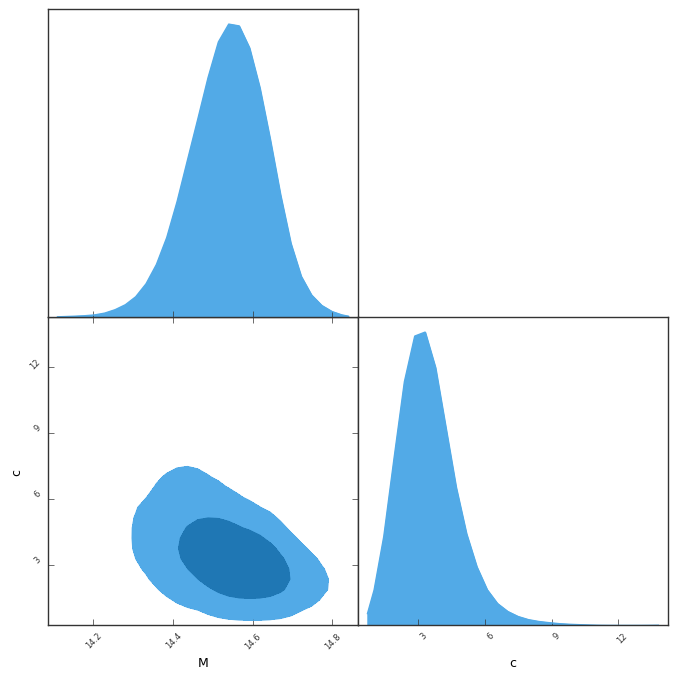

Esecuzione di emcee per bin 45 <= Lambda < 60...


100%|██████████| 3000/3000 [00:52<00:00, 57.27it/s]


Risultati per bin 45 <= Lambda < 60:
M = 14.698 (-0.088/+0.081)
c = 3.533 (-1.030/+1.227)
Chi-quadrato per il best fit: 0.204


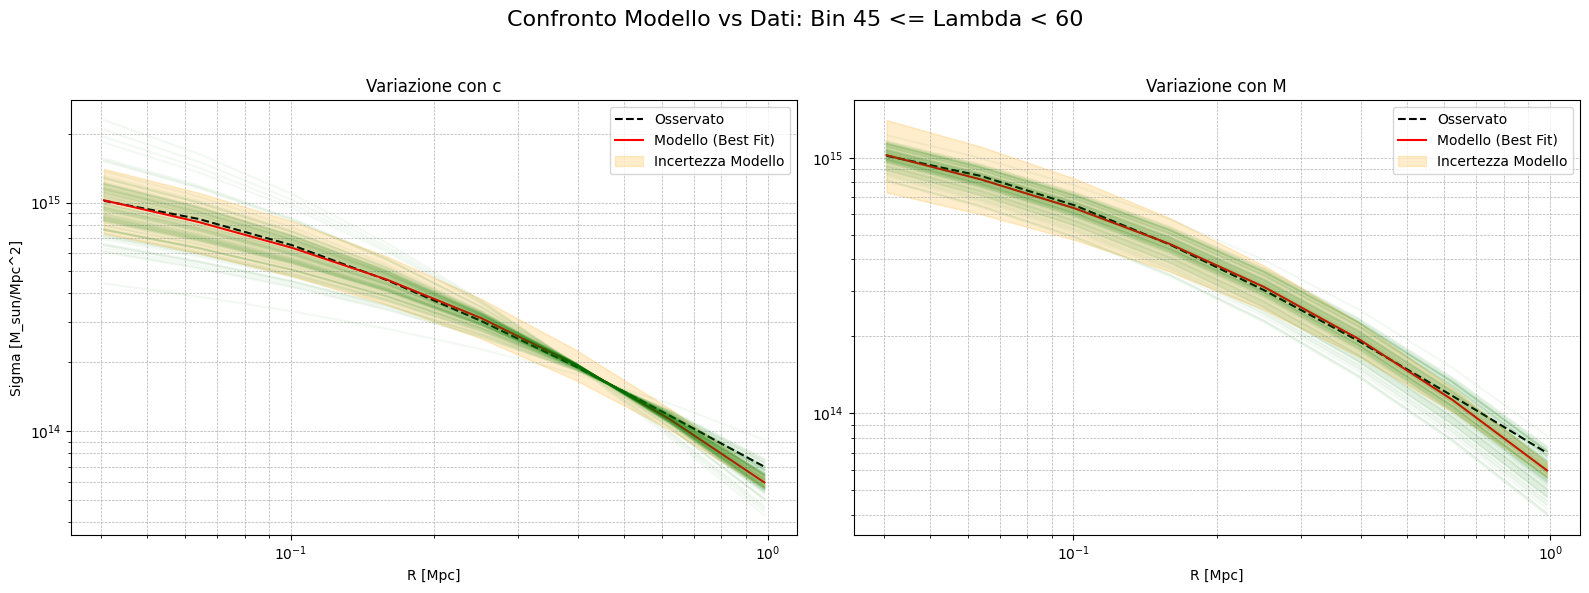

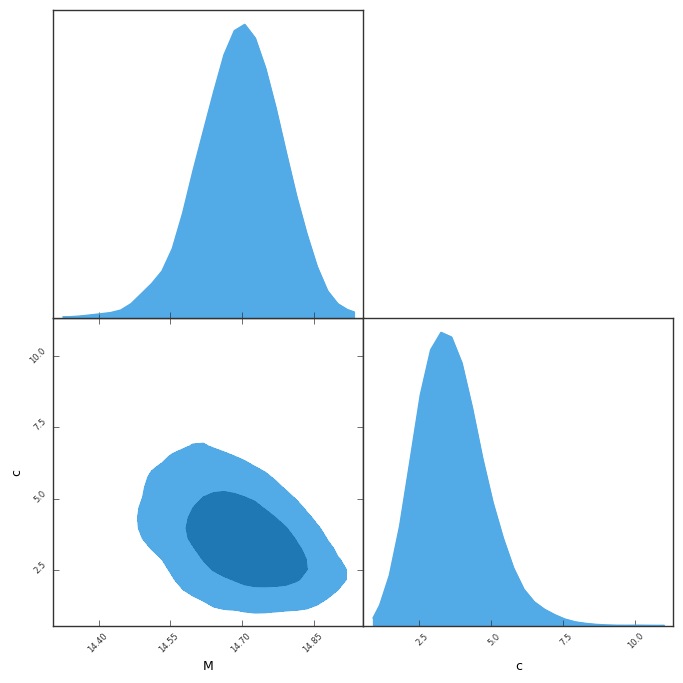

Esecuzione di emcee per bin 60 <= Lambda < 200...


100%|██████████| 3000/3000 [00:52<00:00, 57.51it/s]


Risultati per bin 60 <= Lambda < 200:
M = 14.890 (-0.119/+0.105)
c = 3.825 (-1.186/+1.579)
Chi-quadrato per il best fit: 0.138


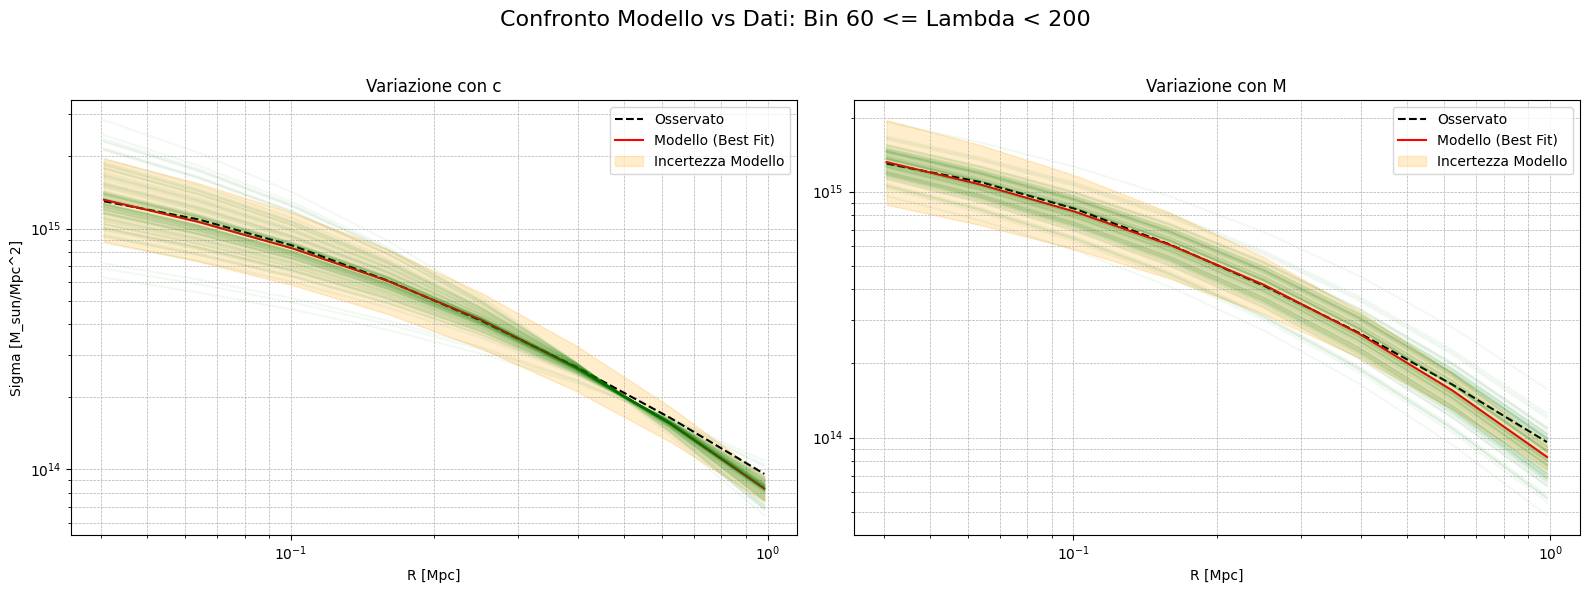

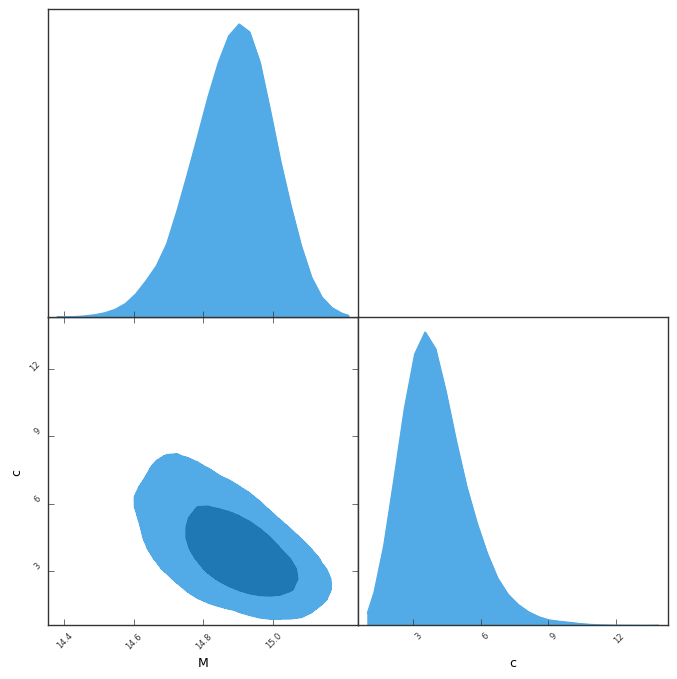

In [14]:

covariances = np.load("covariance_matrices.npy")

#Funzione di log-likelihood
def log_likelihood(params, R, Sigma_obs, covariance, z):
    M, c = params  # Decodifica dei parametri

    # Calcolo del modello NFW
    model = nfw_density_profile(R, 10**M, c, z)  # Nota: M è in log10(M)
    if np.any(np.isnan(model)) or np.any(np.isinf(model)):
        print(f"Valori non finiti nel modello: {model}")
        return -np.inf

    # Calcolo dei residui
    residual = Sigma_obs - model

    # Calcolo della likelihood
    inv_cov = np.linalg.inv(covariance)  # Inversa della matrice di covarianza
    det_cov = np.linalg.det(covariance)  # Determinante della matrice di covarianza
    p,_ = covariance.shape
    log_like = -0.5 * (residual.T @ inv_cov @ residual + np.log(det_cov)) - 0.5 * p * np.log(2 * np.pi)

    if not np.isfinite(log_like):
        print("Log-likelihood non valida.")
    return log_like

# Funzione log-prior
def log_prior(theta):
    M, c = theta  # Decodifica dei parametri
    if 13 <= M <= 16 and 0.2 <= c <= 20:
        return 0.0  # Prior uniforme, log(1) = 0
    return -np.inf  # Escludi valori fuori dal range

# Funzione log-posterior
def log_probability(theta, R, Sigma_obs, covariance, z):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    # Somma il log-likelihood
    return lp + log_likelihood(theta, R, Sigma_obs, covariance, z)

# Parametri iniziali
M0 = 14.0  # Valore iniziale per log10(M)
c0 = 4.0   # Valore iniziale per c
theta = [M0, c0]  # Parametri iniziali

# Definizione della funzione per minimizzare il log-posterior
np.random.seed(42)
nll = lambda *args: -log_probability(*args)  # Negativo del log-posterior
initial = np.array(theta)  # Parametri iniziali come array





results=[]
# Aggiungiamo il calcolo di chi-quadrato (χ²)
def chi_squared(Sigma_obs, Sigma_model, Sigma_std):
    # Calcola il chi-quadrato tra i dati osservati e il modello
    residuals = (Sigma_obs - Sigma_model) / Sigma_std
    chi2 = np.sum(residuals**2)
    return chi2

# Modifica del codice di salvataggio dei risultati e calcolo di chi-quadrato
for i in range(len(lambda_bins) - 1):
    lower, upper = lambda_bins[i], lambda_bins[i + 1]
    mask = (richness >= lower) & (richness < upper)

    if np.sum(mask) == 0:
        print(f"Nessun dato nell'intervallo {lower} <= Lambda < {upper}")
        continue

    redshift_mean = np.mean(redshift[mask])
    Sigma_obs = np.mean(density_profiles[mask], axis=0)
    density_std = np.std(density_profiles[mask], axis=0)  # Deviazione standard per i dati osservati
    covariance = covariances[i]

    # Minimizzazione per trovare il punto di partenza
    soln = minimize(nll, initial, args=(R_values, Sigma_obs, covariance, redshift_mean))

    # Impostazione per emcee
    nparams = len(theta)
    pos = soln.x * (1 + 1e-4 * np.random.randn(32, nparams))  # Inizializzazione dei walker
    nwalkers, ndim = pos.shape

    # Definizione del sampler
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(R_values, Sigma_obs, covariance, redshift_mean)
    )

    # Run dell'MCMC
    print(f"Esecuzione di emcee per bin {lower} <= Lambda < {upper}...")
    sampler.run_mcmc(pos, 3000, progress=True)

    # Campioni appiattiti
    flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)

    # Calcolo dei valori medi e degli errori a 1-sigma
    m_median, c_median = np.median(flat_samples, axis=0)
    m_err_low, c_err_low = np.percentile(flat_samples, 16, axis=0)
    m_err_high, c_err_high = np.percentile(flat_samples, 84, axis=0)

    # Calcolo del chi-quadrato per il best-fit
    Sigma_model_best_fit = nfw_density_profile(R_values, 10**m_median, c_median, redshift_mean)
    chi2_best_fit = chi_squared(Sigma_obs, Sigma_model_best_fit, density_std)

    # Salvataggio dei risultati
    result = {
        "lambda_range": (lower, upper),
        "M": m_median,
        "c": c_median,
        "M_err": (m_median - m_err_low, m_err_high - m_median),
        "c_err": (c_median - c_err_low, c_err_high - c_median),
        "density_mean": Sigma_obs,
        "density_std": density_std,
        "chi2_best_fit": chi2_best_fit
    }
    results.append(result)

    print(f"Risultati per bin {lower} <= Lambda < {upper}:")
    print(f"M = {m_median:.3f} (-{result['M_err'][0]:.3f}/+{result['M_err'][1]:.3f})")
    print(f"c = {c_median:.3f} (-{result['c_err'][0]:.3f}/+{result['c_err'][1]:.3f})")
    print(f"Chi-quadrato per il best fit: {chi2_best_fit:.3f}")







    # Estrarre 100 campioni di c e M dalle catene
    c_samples = flat_samples[:, 1]
    c_samples_100 = np.random.choice(c_samples, size=100, replace=False)

    m_samples = flat_samples[:, 0]
    m_samples_100 = np.random.choice(m_samples, size=100, replace=False)

    # Calcolo delle bande di errore per il modello (best fit)
    Sigma_model_low = nfw_density_profile(R_values, 10**(m_median - result["M_err"][0]), c_median - result["c_err"][0], redshift_mean)
    Sigma_model_high = nfw_density_profile(R_values, 10**(m_median + result["M_err"][1]), c_median + result["c_err"][1], redshift_mean)

    # Creazione del subplot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Confronto Modello vs Dati: Bin {lower} <= Lambda < {upper}", fontsize=16)

    # Plot 1: Variazione con c
    axes[0].plot(R_values, Sigma_obs, label="Osservato", color="black", linestyle="--", linewidth=1.5)
    axes[0].plot(R_values, Sigma_model_best_fit, label="Modello (Best Fit)", color="red", linewidth=1.5)
    axes[0].fill_between(
        R_values, Sigma_model_low, Sigma_model_high, color="orange", alpha=0.2, label="Incertezza Modello"
    )
    for c_sample in c_samples_100:
        Sigma_model_sample = nfw_density_profile(R_values, 10**m_median, c_sample, redshift_mean)
        axes[0].plot(R_values, Sigma_model_sample, color="green", alpha=0.05)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].set_xlabel("R [Mpc]")
    axes[0].set_ylabel("Sigma [M_sun/Mpc^2]")
    axes[0].set_title("Variazione con c")
    axes[0].legend()
    axes[0].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Plot 2: Variazione con M
    axes[1].plot(R_values, Sigma_obs, label="Osservato", color="black", linestyle="--", linewidth=1.5)
    axes[1].plot(R_values, Sigma_model_best_fit, label="Modello (Best Fit)", color="red", linewidth=1.5)
    axes[1].fill_between(
        R_values, Sigma_model_low, Sigma_model_high, color="orange", alpha=0.2, label="Incertezza Modello"
    )
    for m_sample in m_samples_100:
        Sigma_model_sample = nfw_density_profile(R_values, 10**m_sample, c_median, redshift_mean)
        axes[1].plot(R_values, Sigma_model_sample, color="green", alpha=0.05)
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].set_xlabel("R [Mpc]")
    axes[1].set_title("Variazione con M")
    axes[1].legend()
    axes[1].grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


    # Grafico triangolare con pygtc
    pygtc.plotGTC(
        chains=flat_samples,
        paramNames=["M", "c"],
        figureSize=8,
        nContourLevels=2,
        filledPlots=True,
        smoothingKernel=1.0,
        colorsOrder=['blues', 'greens']
    )
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.show()

# Discussione dei risultati

Dal fit si sono ottenuti i seguenti risultati:
*  15 < $λ$ < 20 :
    * $\log_{10}(M^*)$ = 14.299 (-0.103/+0.094)
    * $c^*$ = 2.960 (-1.027/+1.436)
    * $χ^2$ = 0.597
*  20 < $λ$ < 30 :
    * $\log_{10}(M^*)$ = 14.378 (-0.100/+0.091)
    * $c^*$ = 3.077 (-1.022/+1.392)
    * $χ^2$ = 0.497
*  30 < $λ$ < 45 :
    * $\log_{10}(M^*)$ = 14.543 (-0.099/+0.088)
    * $c^*$ = 3.281 (-1.019/+1.313)
    * $χ^2$ = 0.295
*  45 < $λ$ < 60 :
    * $\log_{10}(M^*)$ = 14.698 (-0.088/+0.081)
    * $c^*$ = 3.533 (-1.030/+1.227)
    * $χ^2$ = 0.204
*  60 < $λ$ < 200 :
    * $\log_{10}(M^*)$ = 14.890 (-0.119/+0.105)
    * $c^*$ = 3.825 (-1.186/+1.579)
    * $χ^2$ = 0.138

Si nota il valore di $\chi^2$ molto minore dal valore atteso dalla teoria, infatti dalla teoria ci si aspetta $\chi^2 \approx 8$, essendo il vettore R_values di cardinalità 8 e il contributo medio per ciascun punto $\chi^2_1 \approx 1$. Ciò suggerisce una sovrastima degli errori associati ai dati